In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8) 

from sklearn import set_config, preprocessing # предобработка
set_config(transform_output='pandas')
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam



%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df = data.copy()

In [5]:
df['Log_Pass'] = np.log(df['Passengers'])
df['Diff_Log_Pass'] = df['Log_Pass'].diff()

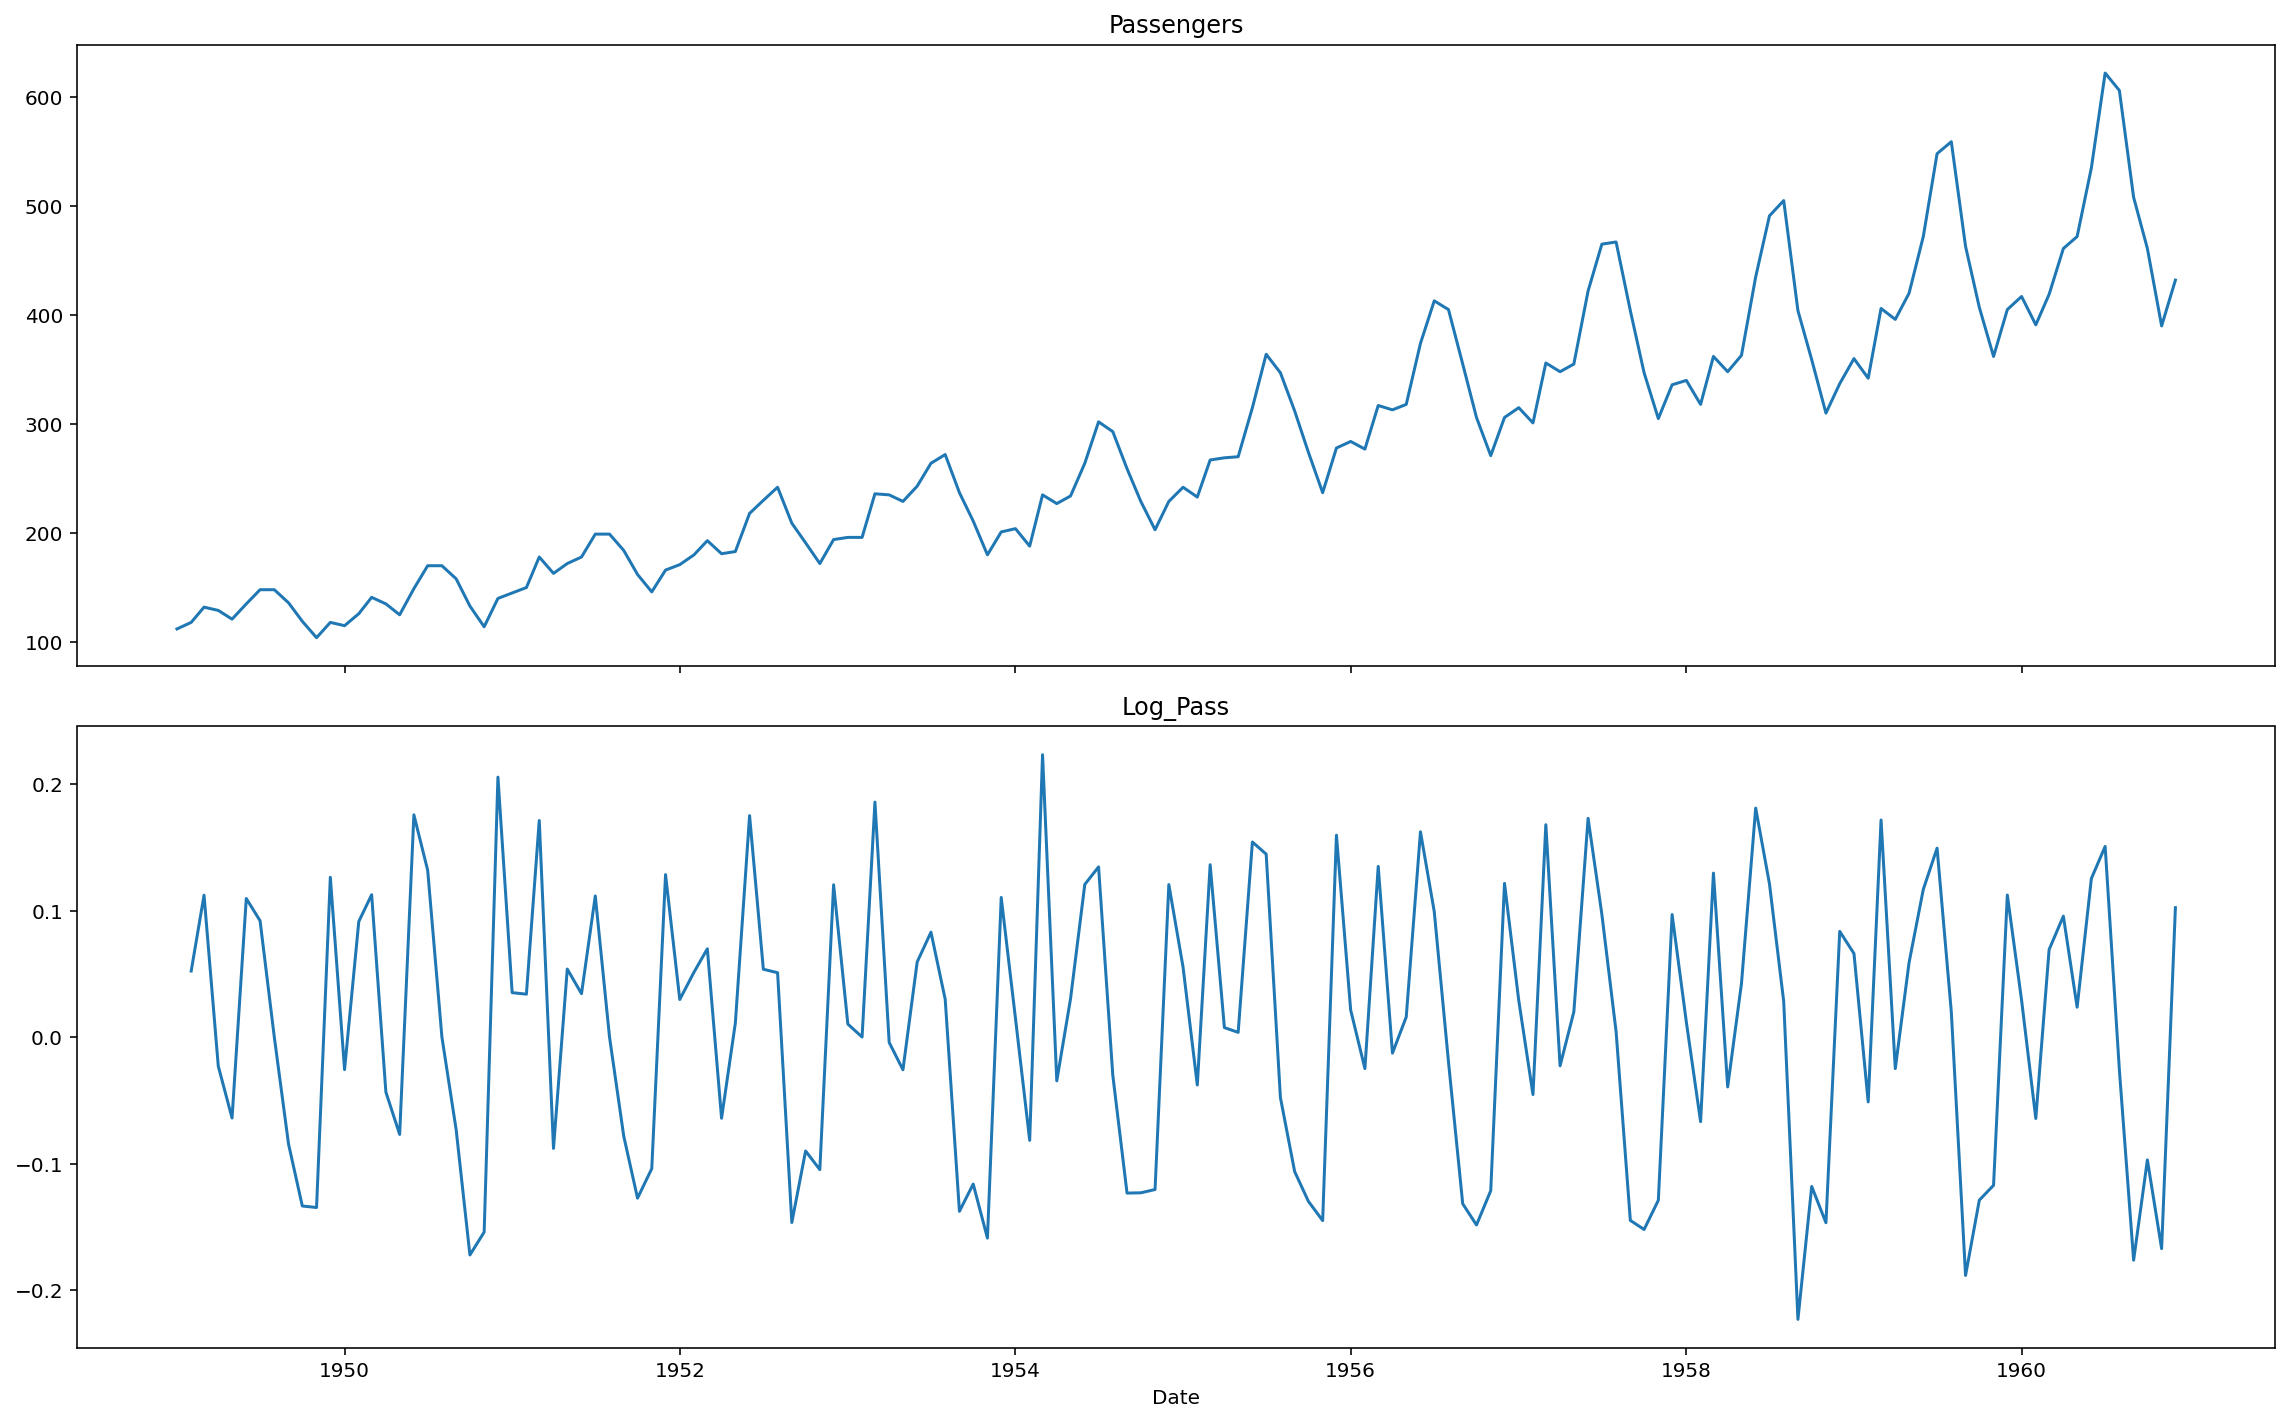

In [6]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
ind = df.index.to_numpy()
_0 = df['Passengers'].to_numpy()
_1 = df['Diff_Log_Pass'].to_numpy()

ax[0].plot(ind, _0)
ax[0].set_title('Passengers')

ax[1].plot(ind, _1)
ax[1].set_title('Log_Pass')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [10]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [15]:
adf(df['Diff_Log_Pass'].values[1:])

Test-Statistic: -2.717130598388133
P-Value: 0.07112054815085875
Non-Stationary


Не совсем вышло, попытались сделать ряд стационарным. При пороге в 10% он был бы таким.

### Split data

In [225]:
N_test = 12 # Сколько элементов в конце оставить на тестовую выборку
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

### Create supervised dataset
Трансформируя исходый временной ряд получаю датасеты X, y. Т.е. фактически зам генерирую/размечаю данные.

In [226]:
series = df['Diff_Log_Pass'].values[1:]

In [227]:
T = 10 # длина истории, котрая используется для прогноза следующего элемента
N = len(series) - T # Num of samples in dataset
X = []
y = []

for t in range(N):
    X.append(series[t:t+T]) # first T elements
    y.append(series[t+T]) # next element for prediction

In [228]:
X = np.array(X).reshape(-1, T)
y = np.array(y)

In [229]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (134, 10) y.shape: (134,)


Split dataset

In [230]:
X_train, X_test = X[:-N_test], X[-N_test:]
y_train, y_test = y[:-N_test], y[-N_test:]

### 1-step forecast
Пу сути это прогноз только одного будущего значения. Только на один шаг. Следующее значение можно предсказать только когда появится предыдущее.

Они ведь и сохранены у нас в матрице признаков X.

In [231]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

После обучения модели можно сразу получить метрики

In [232]:
lr.score(X_train, y_train)

0.9599443783339897

In [233]:
lr.score(X_test, y_test)

0.6910953044565575

Или вот так классическим путем, через получение векторов предсказаний

In [234]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [235]:
r2_score(y_train, y_train_pred)

0.9599443783339897

In [236]:
r2_score(y_test, y_test_pred)

0.6910953044565575

In [237]:
mean_absolute_percentage_error(y_test, y_test_pred)

0.012613783531097338

In [238]:
# Bollean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# устанавливаю индесы вручную для первых T элементов в временном ряду, т.к. тут накапливаятся история нужной длины для последующего предсказания
train_idx[:T] = False

In [239]:
df.loc[train_idx, 'LR_1step_train'] = y_train_pred
df.loc[test_idx, 'LR_1step_test'] = y_test_pred

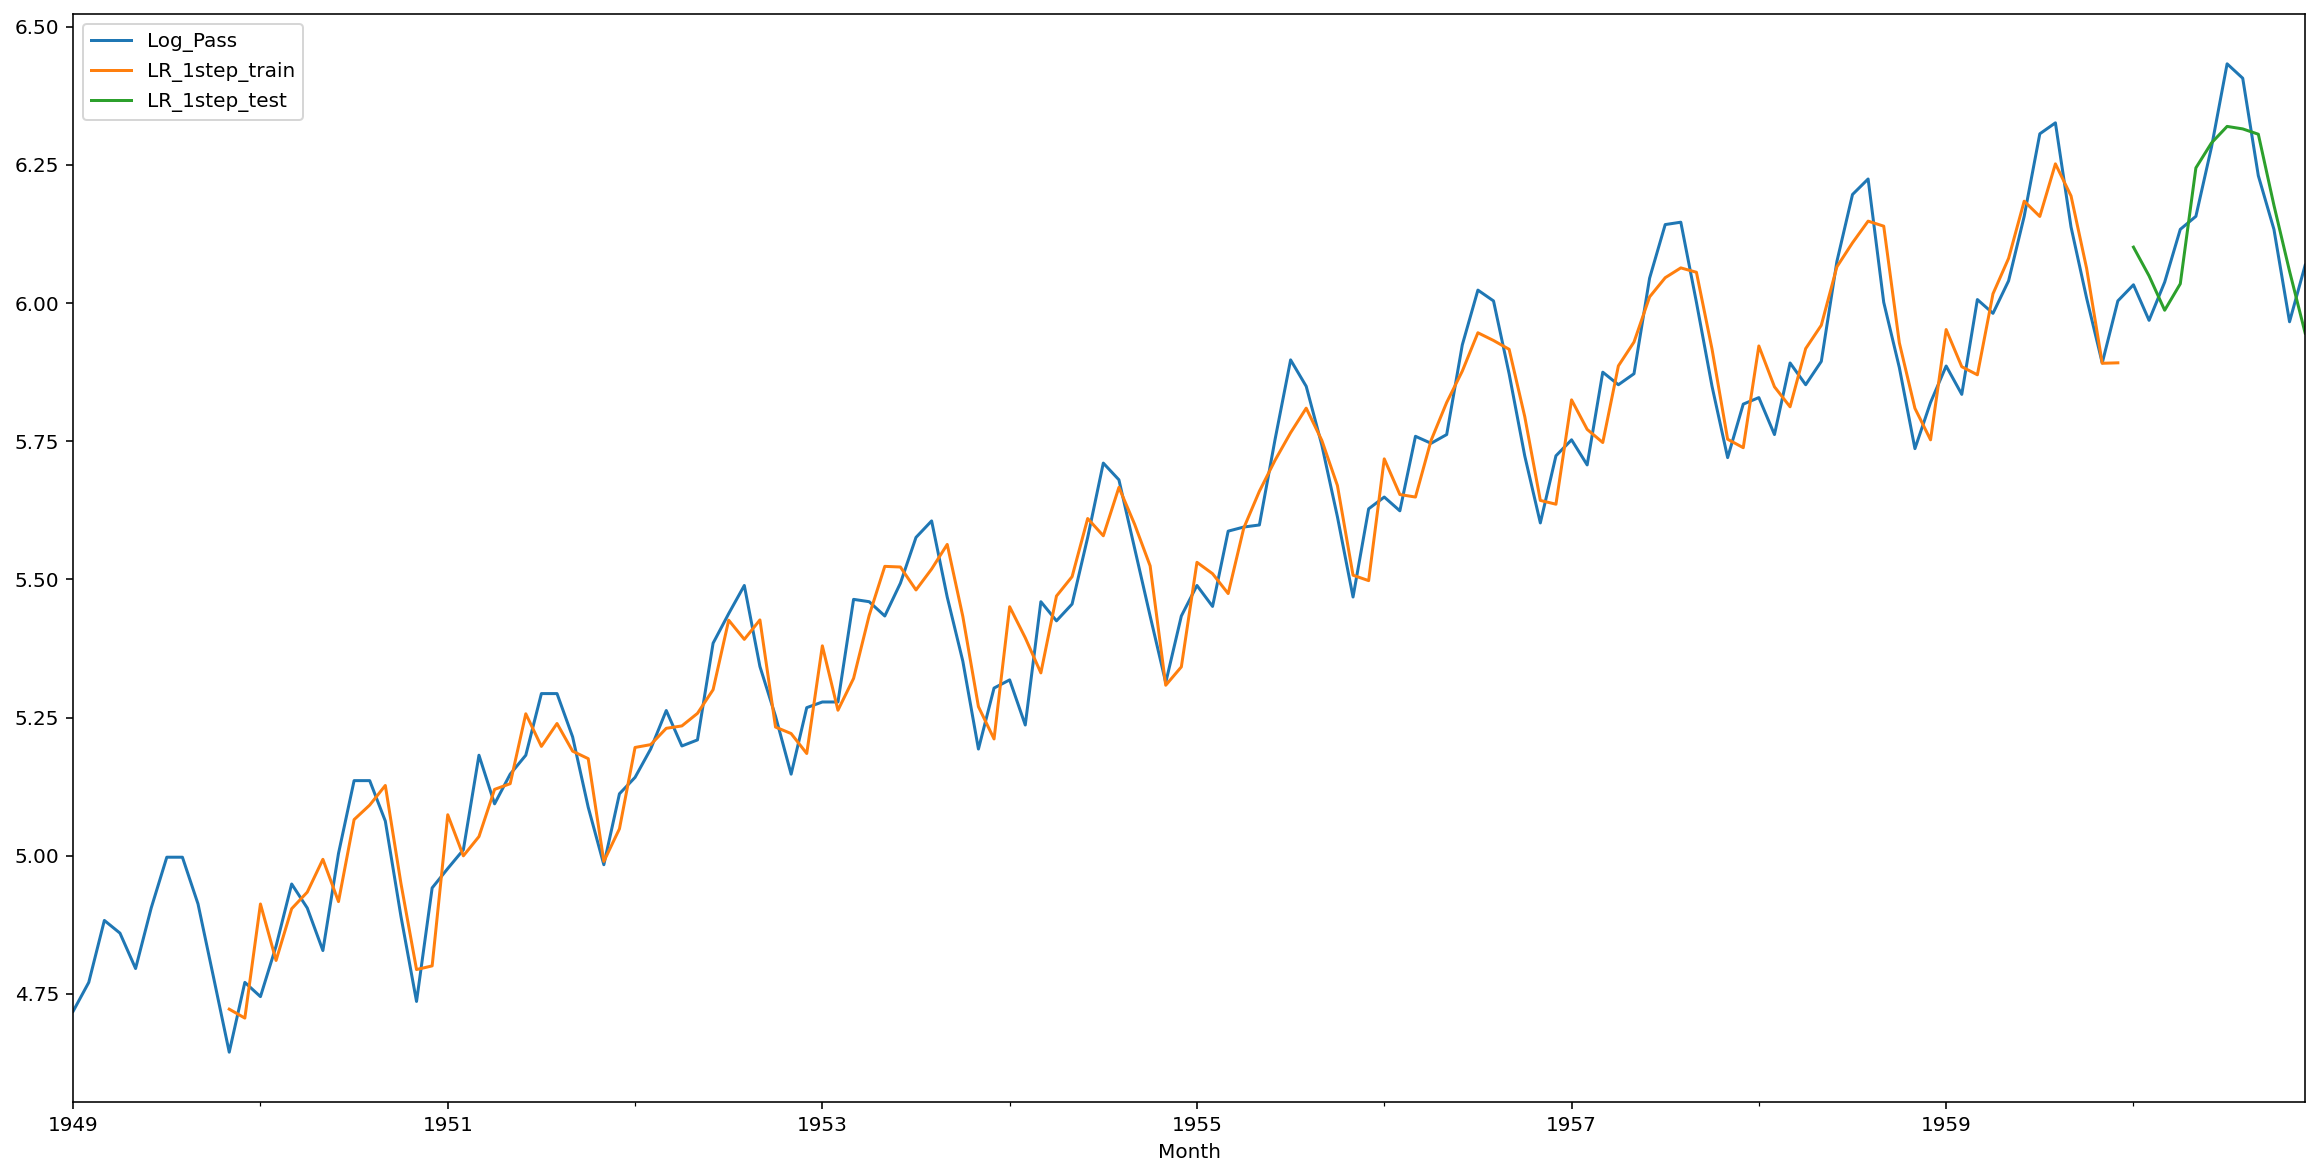

In [240]:
df[['Log_Pass', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(20, 10));

Видно, что модель недооценивает пики, ну и нельзя сказать что идеально отрабатывает. Не забываю, что это прогноз только на один шаг вперед

### Multi-step forecast

In [241]:
multistep_predictions = []

# first test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # save prediction
    multistep_predictions.append(p)
    
    # make new input, add last predict value as input
    last_x = np.roll(last_x, -1) # сдвигаю радя влево в массиве
    last_x[-1] = p # на место последнего значения ставлю полученный прогноз

In [242]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

In [243]:
r2_score(y_test, multistep_predictions)

0.6690512603308051

In [244]:
multistep_mape = mean_absolute_percentage_error(y_test, multistep_predictions)
multistep_mape

0.012229325023475209

# MAPE для multistep даже чуть лучше чем для 1step

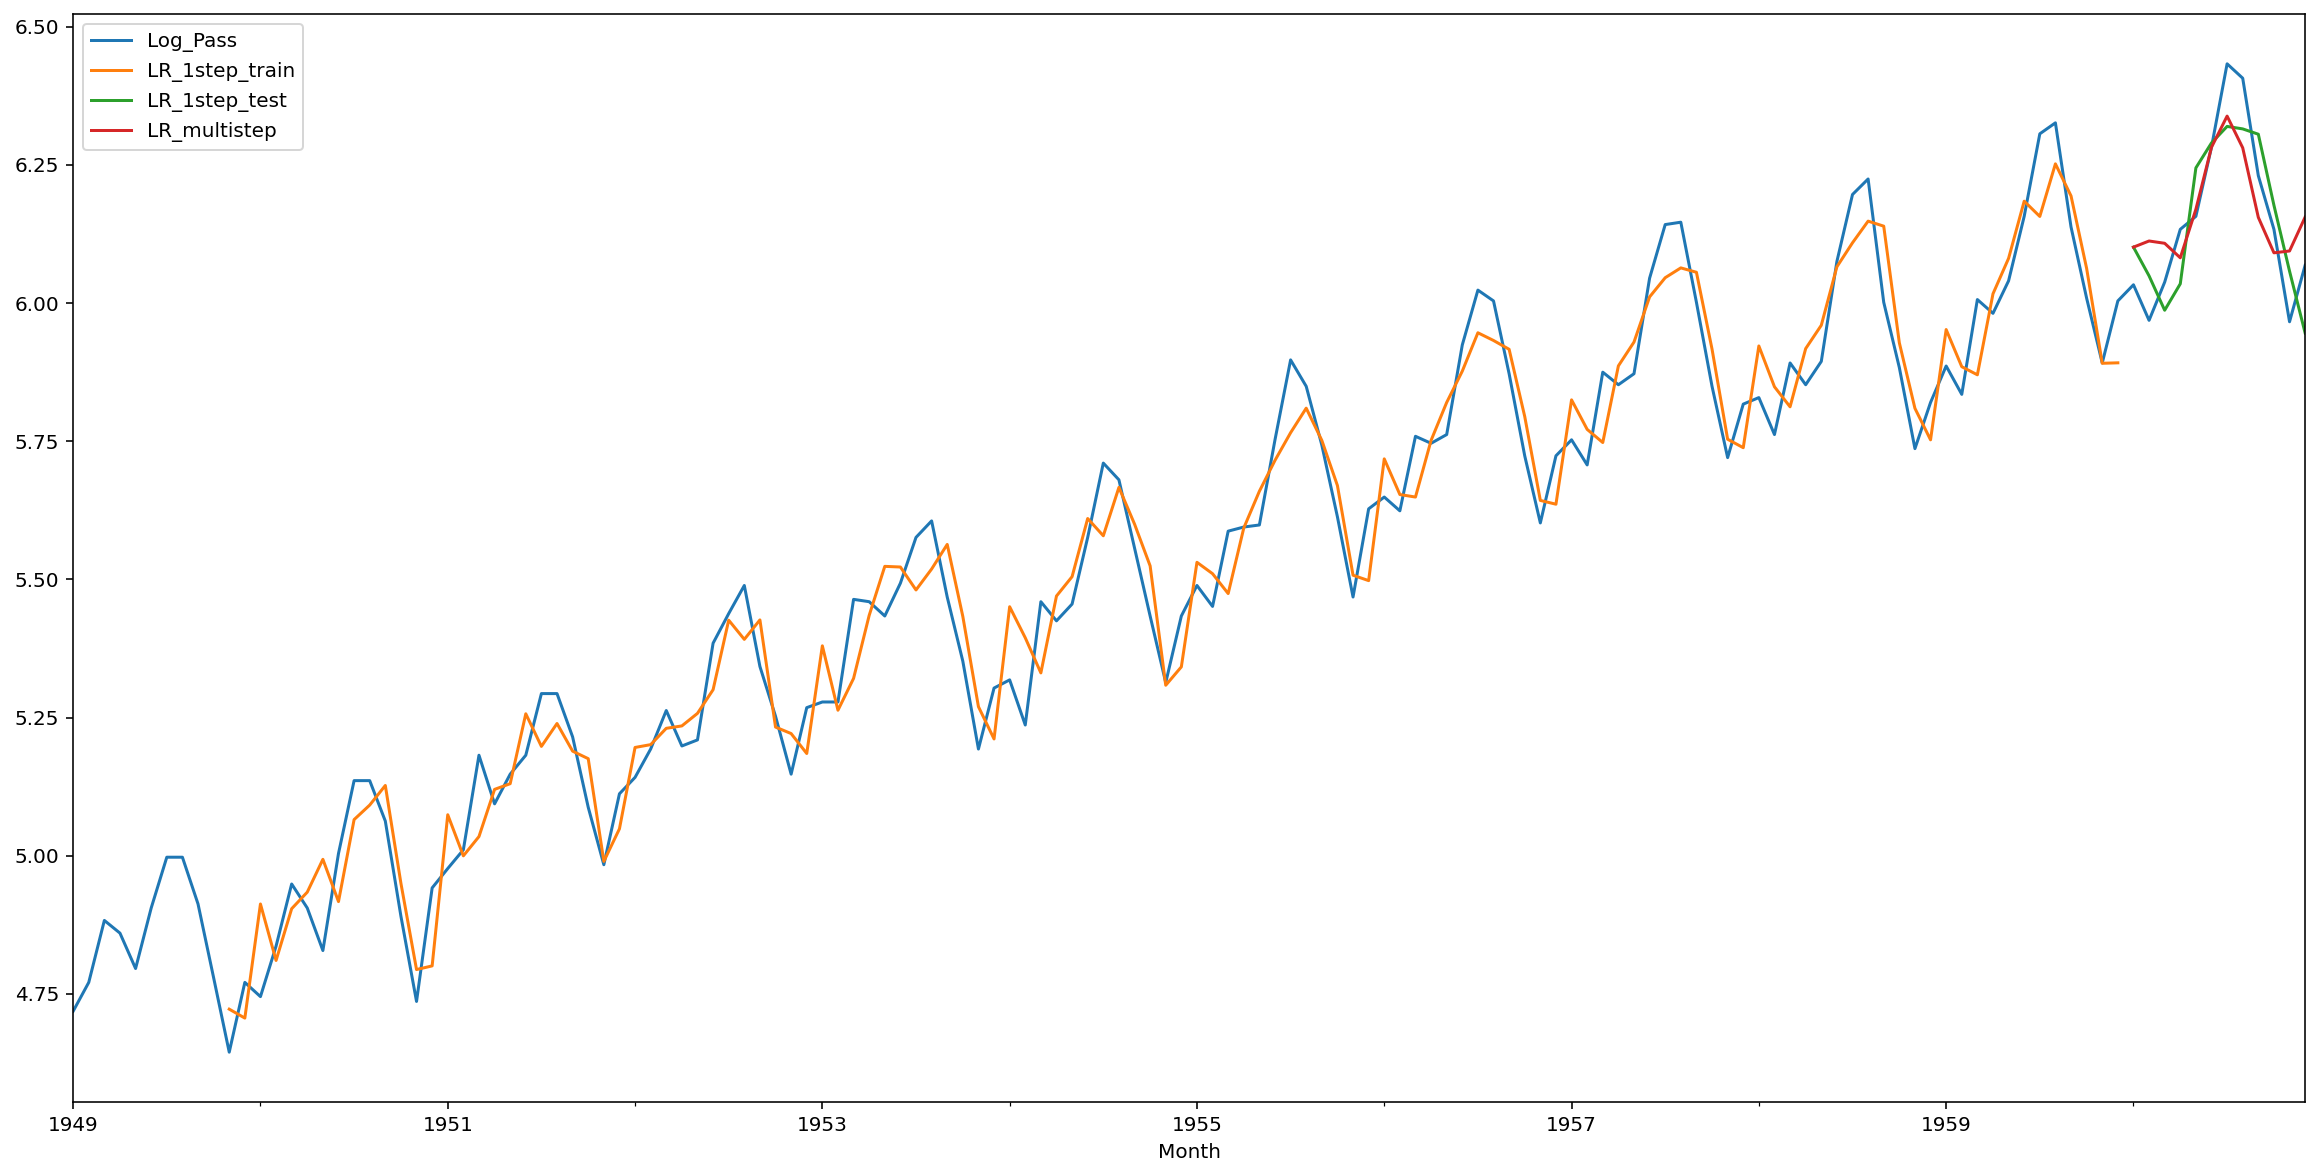

In [245]:
df[['Log_Pass', 'LR_1step_train', 'LR_1step_test', 'LR_multistep']].plot(figsize=(20, 10));

В таком виде результат хуже, но честнее, если мы предполагаем что предсказываем ни на один шаг вперед.

### Create multi-output model
Строми модель, которая на этапе прогноза будет возвращать не одно значений, а массив.

In [246]:
Tx = T # длина истории входящих признаков
Ty = N_test # количество целевых признаков, которые модель выдаст в виде предсказания. Т.е. на сколько шагов вперед производить прогнозирование.
N = len(series) - Tx - Ty # итоговая длина датасета после создания

X = []
y = []

for t in range(len(series) - Tx - Ty + 1):
    X.append(series[t:t+Tx]) # признаки как и прежде сохраняю в виде массива длиной Tx
    y.append(series[t+Tx:t+Tx+Ty]) # а целевая метка теперь не одна, а Ty следующих шагов

In [247]:
X = np.array(X).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)

In [248]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (123, 10) y.shape: (123, 12)


In [249]:
# По сути оставляю в тествовой части только по одной записе, т.к. прогноз будет содержать в реальности 10 шагов вперед
X_train_m, X_test_m = X[:-1], X[-1:]
y_train_m, y_test_m = y[:-1], y[-1:]

In [250]:
# вот 10 шагов целей в тестовом датасете
y_test_m

array([[6.03308622, 5.96870756, 6.03787092, 6.13339804, 6.15697899,
        6.28226675, 6.43294009, 6.40687999, 6.23048145, 6.13339804,
        5.96614674, 6.06842559]])

In [251]:
lr = LinearRegression()
lr.fit(X_train_m, y_train_m)

LinearRegression()

In [252]:
lr.score(X_train_m, y_train_m)

0.9734607773512528

In [253]:
# В таком виде метрика не хочет считаться
lr.score(X_test_m, y_test_m)

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [254]:
y_train_m_pred = lr.predict(X_train_m)
y_test_m_pred = lr.predict(X_test_m)

Т.к. каждый прогноз (как впрочем и целевая метрика) теперь состоит из массива то нужно их оттуда вытаскивать

flatten() или просто через [0]

На тренировочной части метрика не особо релевантна, т.к. в много раз повторяются одни и те же значения

In [255]:
r2_score(y_train_m.flatten(), y_train_m_pred.flatten())

0.9735096160446878

In [256]:
r2_score(y_test_m.flatten(), y_test_m_pred.flatten())

0.8647994522904281

In [257]:
multioutput_mape = mean_absolute_percentage_error(y_test_m.flatten(), y_test_m_pred.flatten())

Метрики на multi-output прям сильно лучше

In [258]:
print('Multistep MAPE:', multistep_mape)
print('Multioutput MAPE:', multioutput_mape)

Multistep MAPE: 0.012229325023475209
Multioutput MAPE: 0.007178924475039767


In [259]:
df.loc[test_idx, 'LR_multioutput'] = y_test_m_pred.flatten()

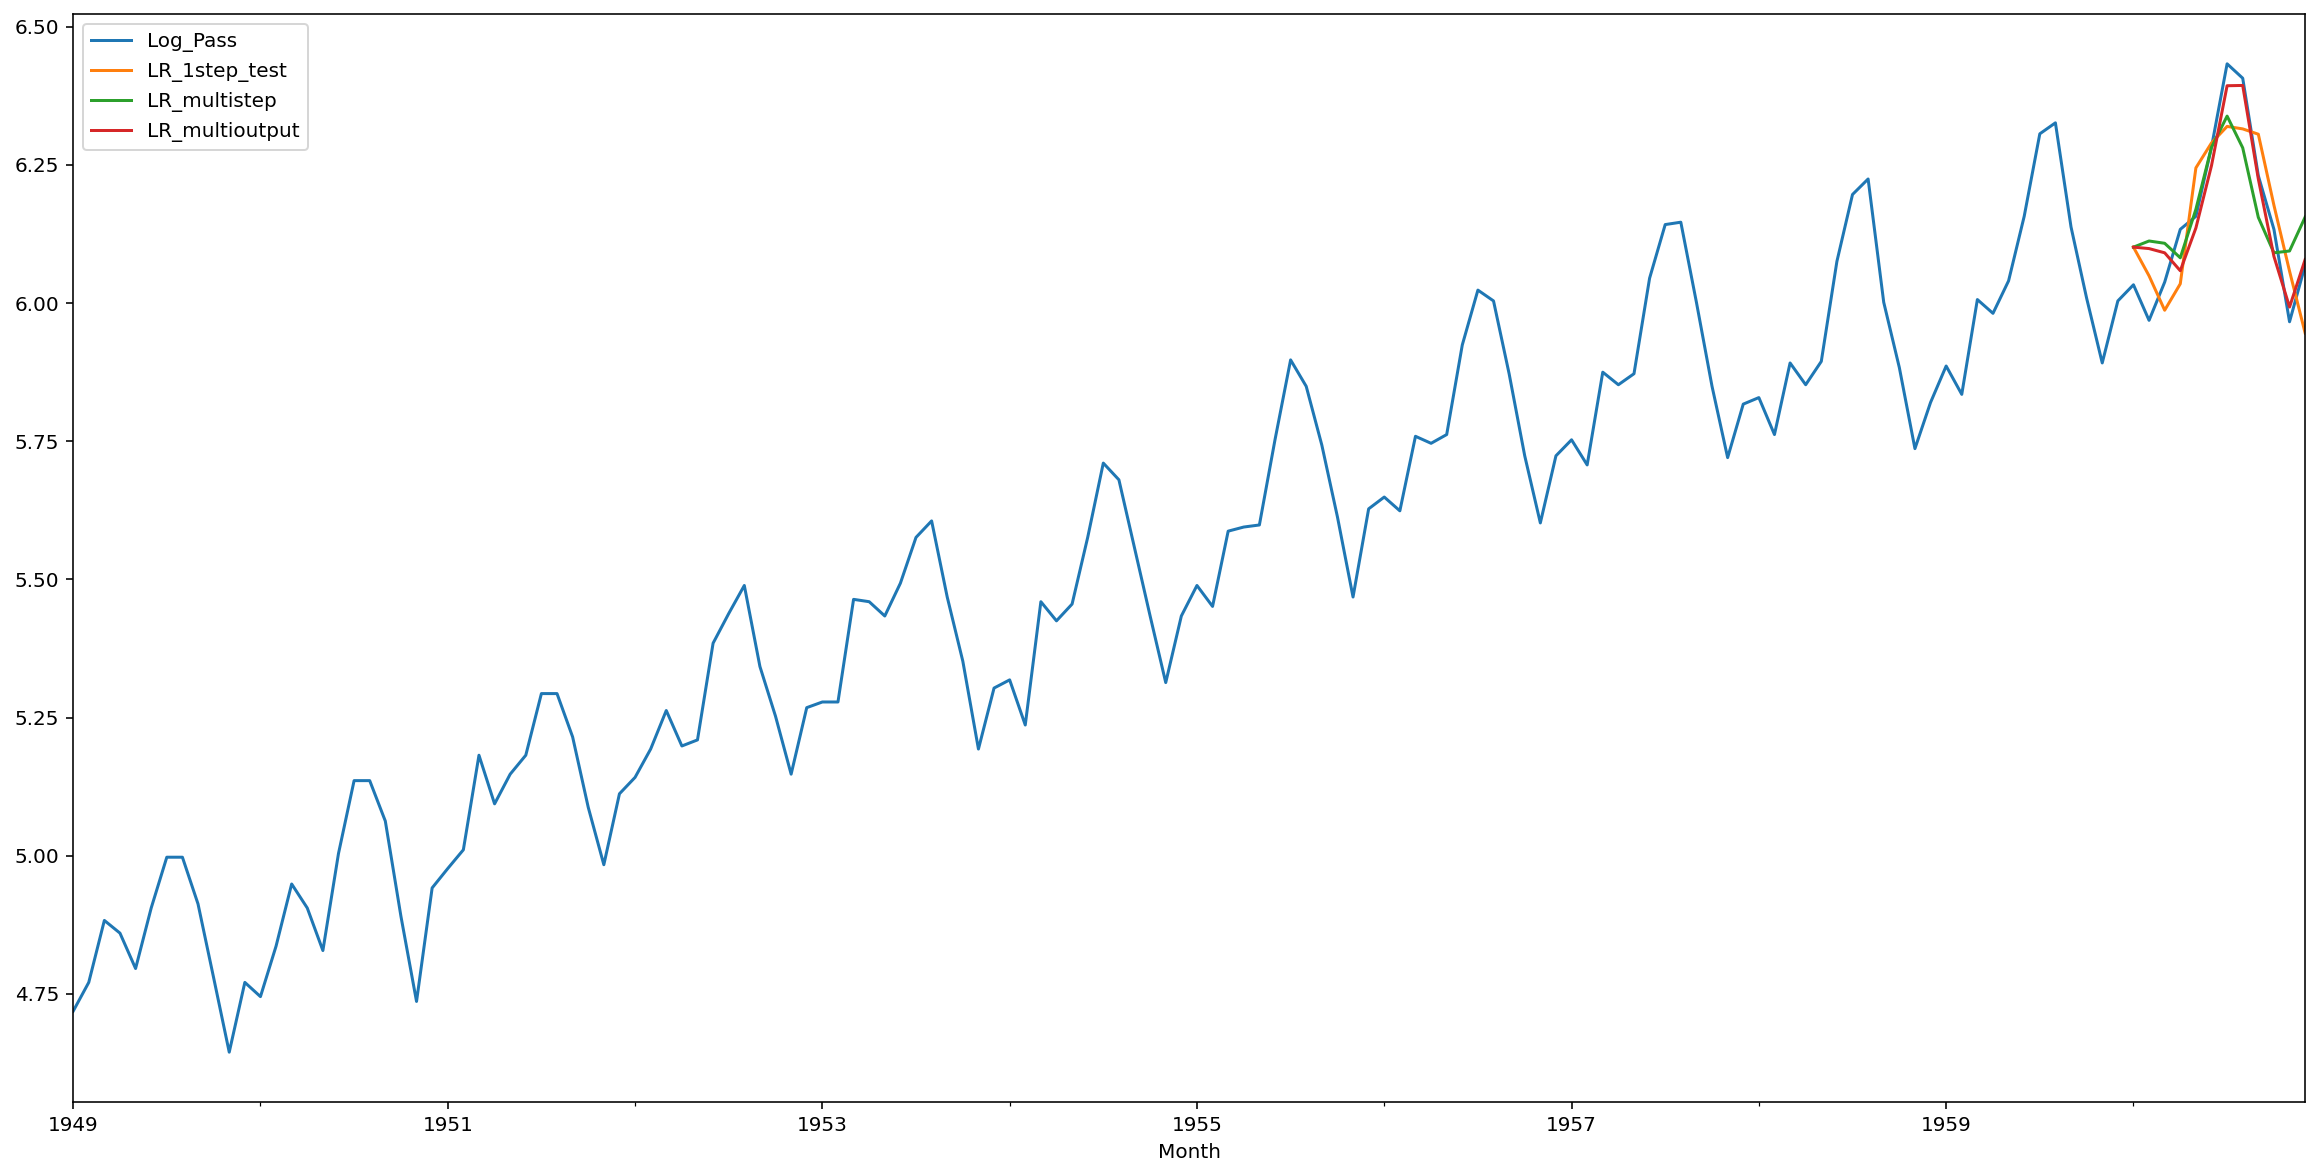

In [260]:
df[['Log_Pass', 'LR_1step_test', 'LR_multistep', 'LR_multioutput']].plot(figsize=(20, 10));

## Test Other Models

In [261]:
def one_stet_and_multi_step_forecast(model, name):
    model.fit(X_train, y_train)
    print('One-step forecast:', name)
    
    # store one-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(X_train)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(X_test)
    
    
    multistep_predictions = []

    # first test input
    last_x = X_test[0]

    while len(multistep_predictions) < N_test:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # save prediction
        multistep_predictions.append(p)
        
        # make new input, add last predict value as input
        last_x = np.roll(last_x, -1) # сдвигаю радя влево в массиве
        last_x[-1] = p # на место последнего значения ставлю полученный прогноз
    
    # store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(y_test, multistep_predictions)
    print(f'MAPE for {name} on test:{mape}')
    
    # plot 1-step and multi-step forecast
    cols = ['Log_Pass',
            f'{name}_1step_train',
            f'{name}_1step_test',
            f'{name}_multistep_test',
            ]
    
    df[cols].plot(figsize=(20, 10));

One-step forecast: SRV
MAPE for SRV on test:0.017529446164230467


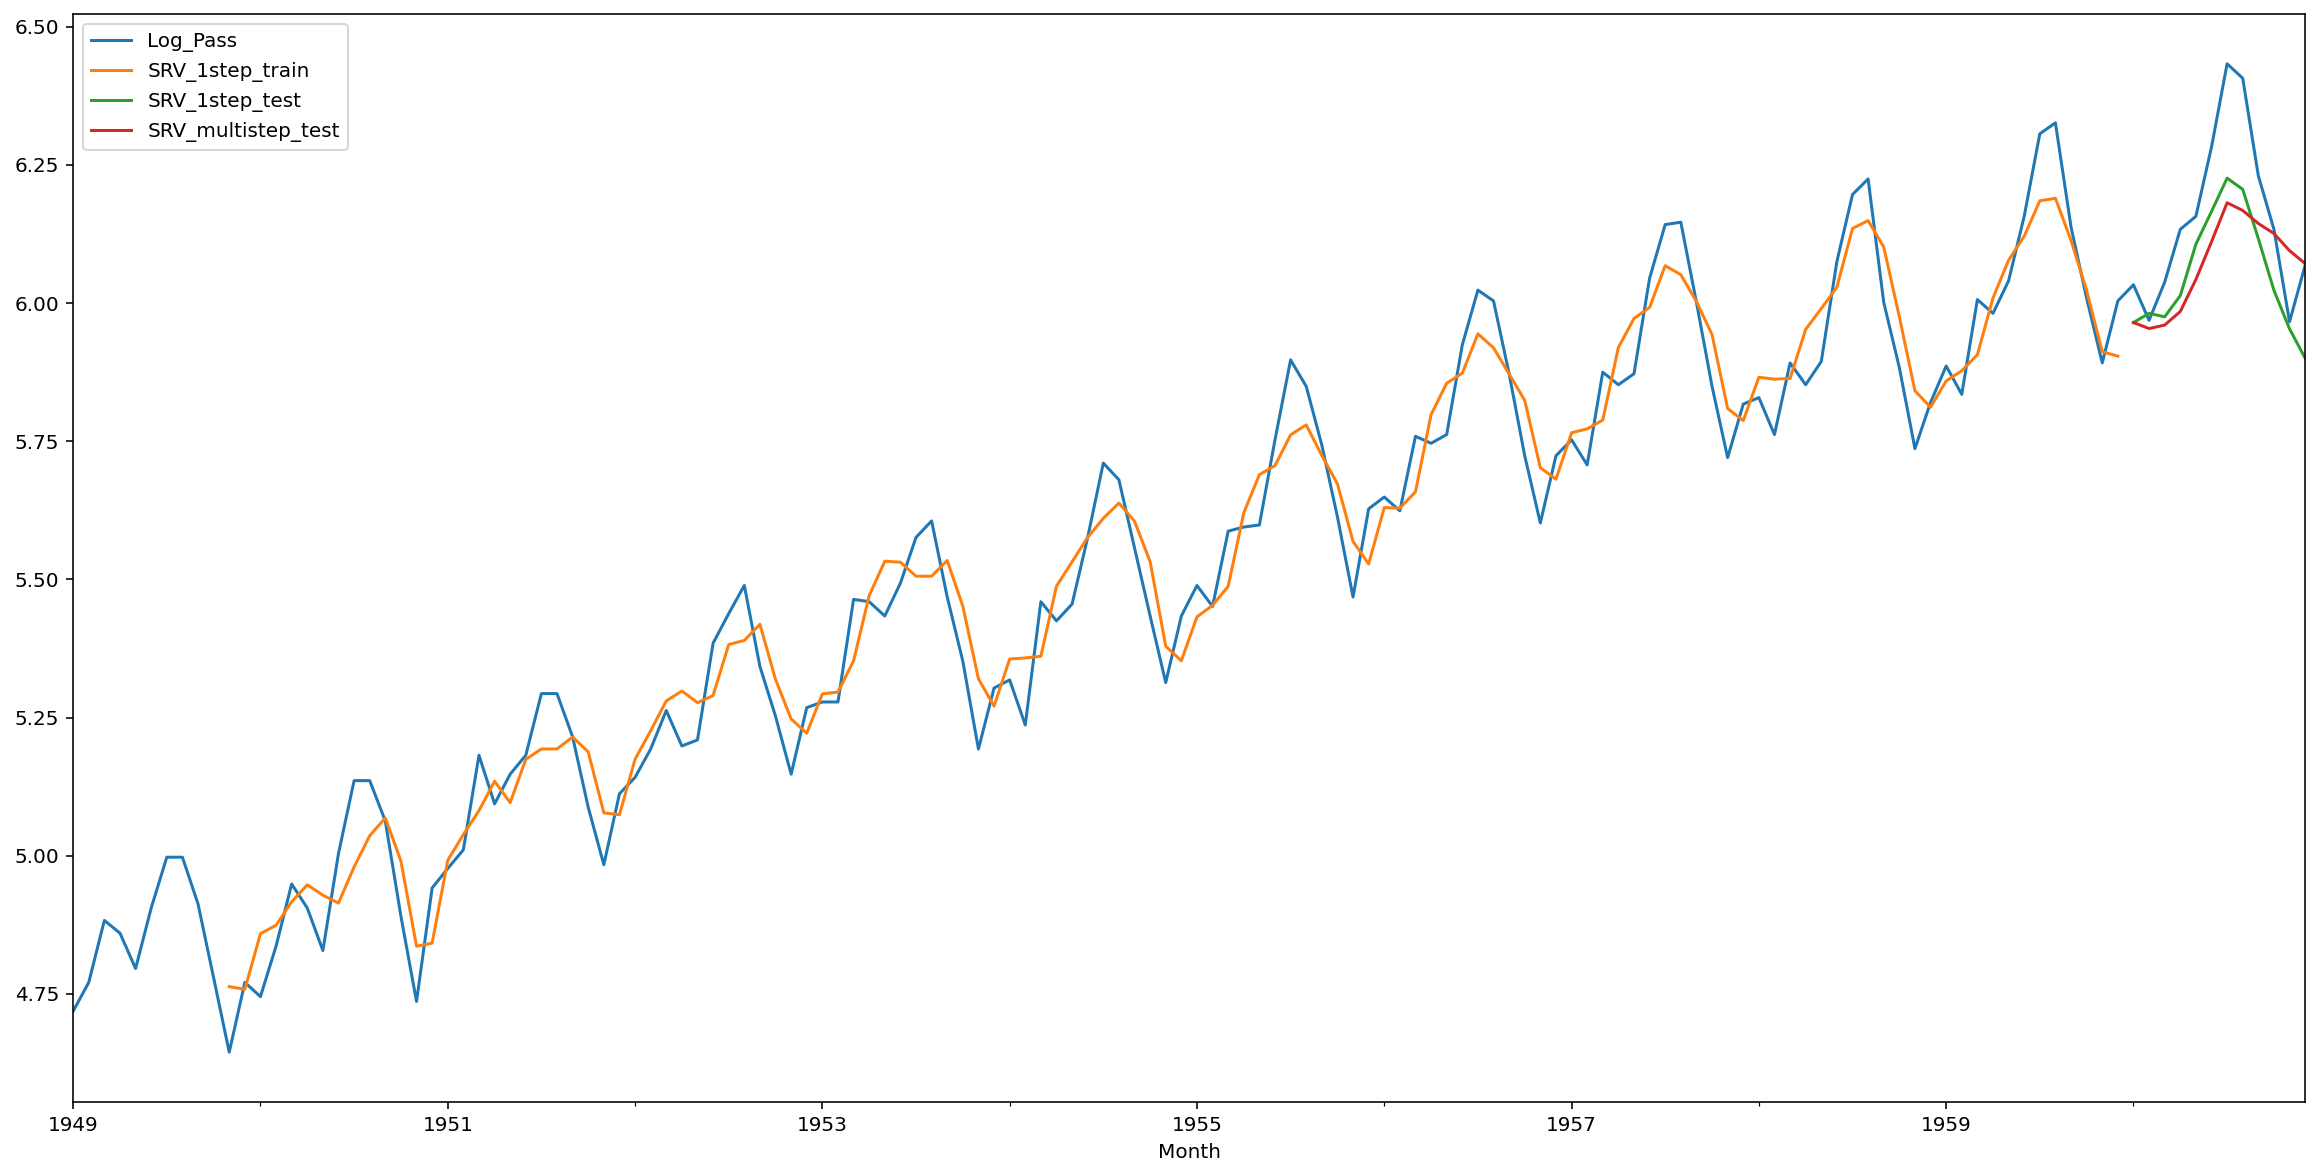

In [262]:
one_stet_and_multi_step_forecast(SVR(), 'SRV')

One-step forecast: RF
MAPE for RF on test:0.02941303708912209


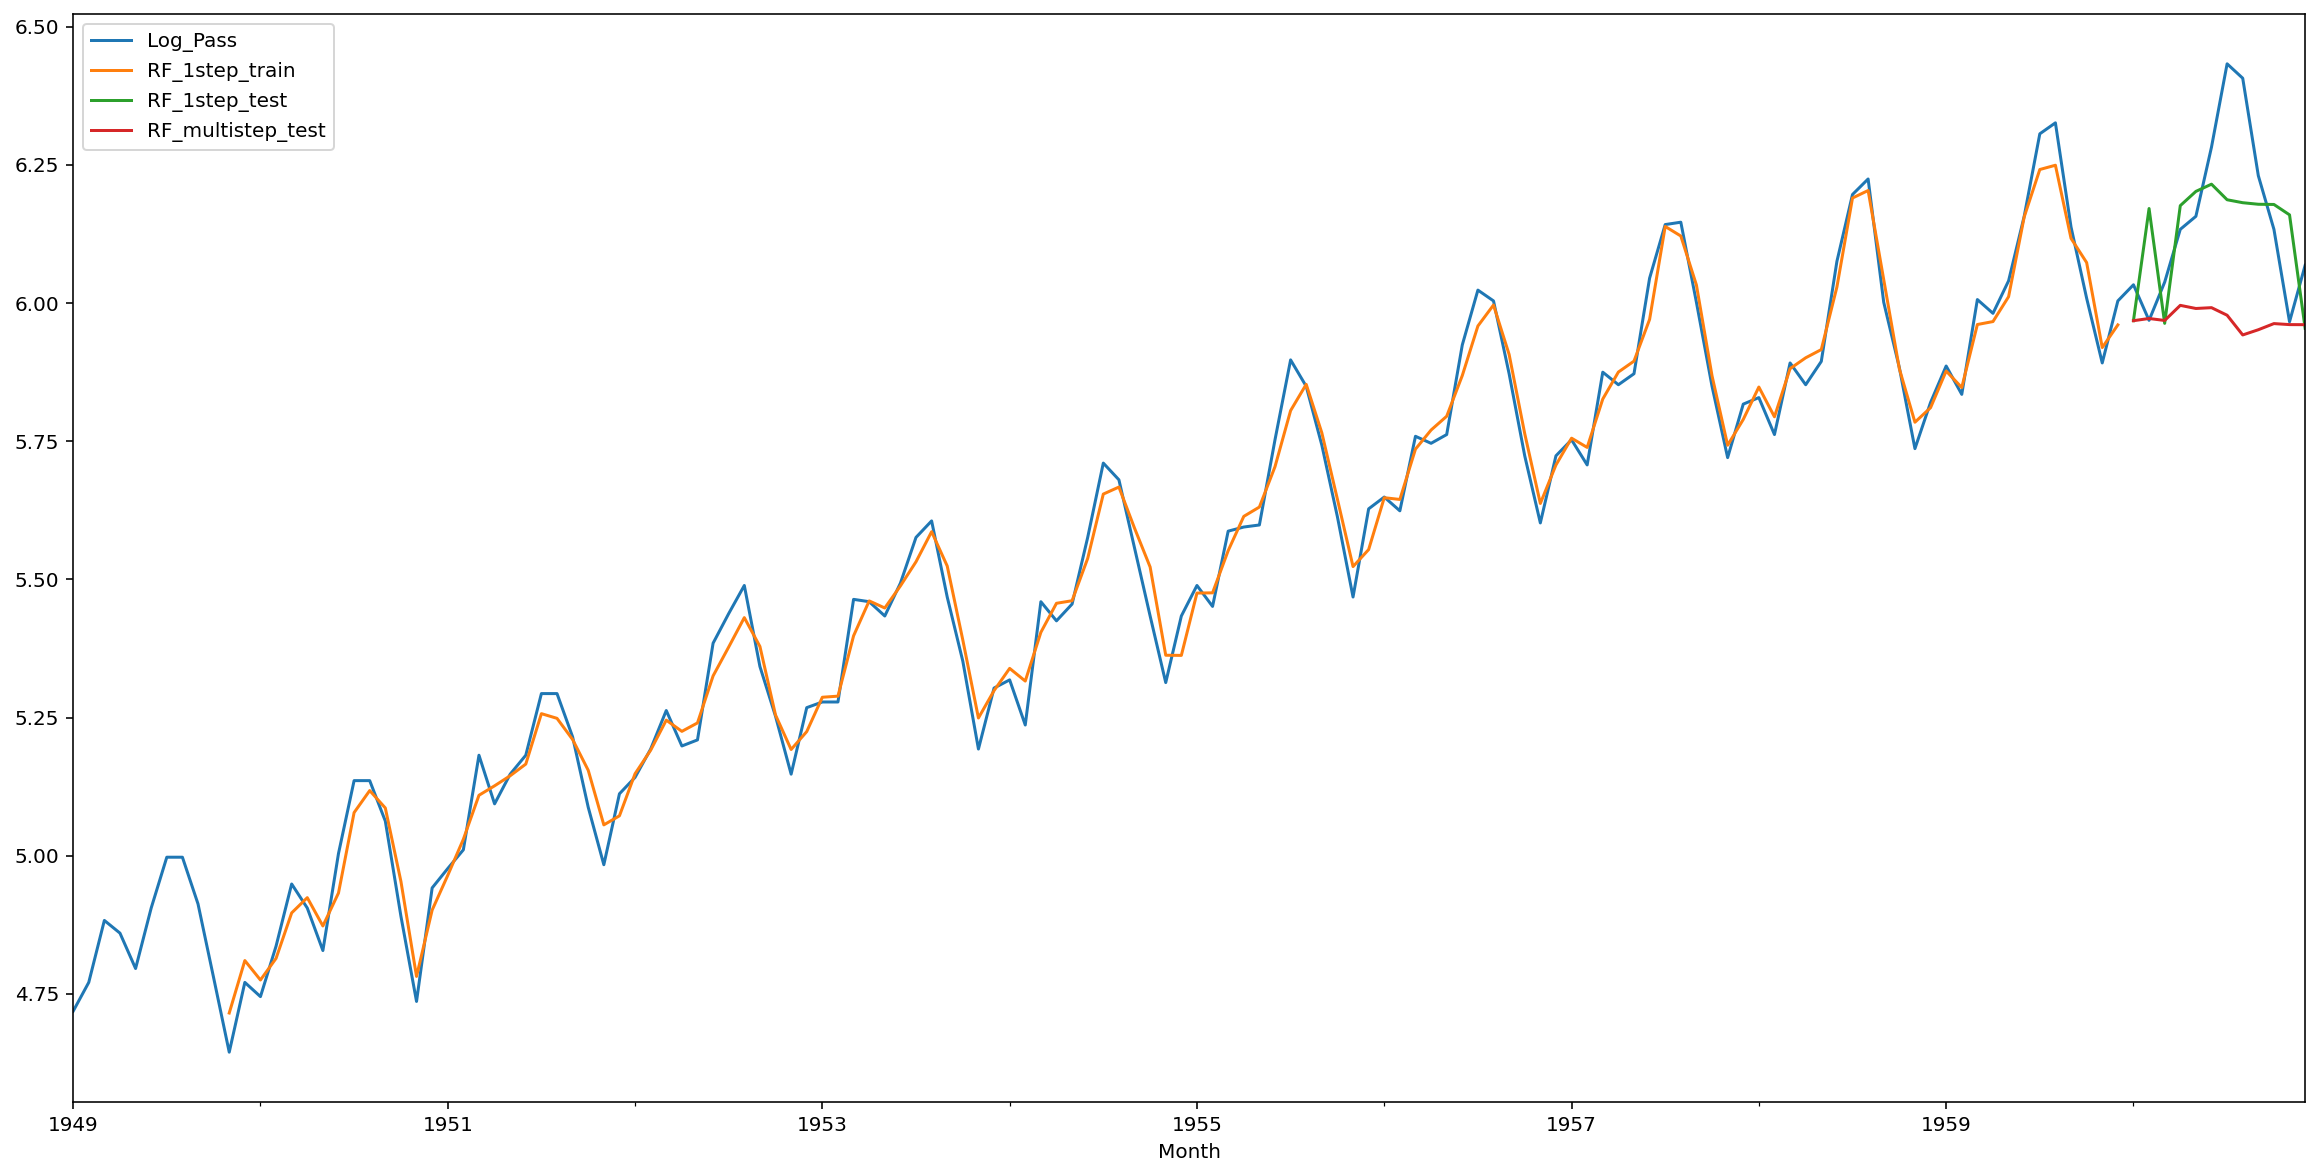

In [263]:
one_stet_and_multi_step_forecast(RandomForestRegressor(), 'RF')

In [270]:
def multi_output_forecast(model, name):
    model.fit(X_train_m, y_train_m)
    y_test_m_pred = model.predict(X_test_m).flatten()
    
    df.loc[test_idx, f'{name}_multioutput_test'] = y_test_m_pred
    
    mape = mean_absolute_percentage_error(y_test_m.flatten(), y_test_m_pred)
    print('Test MAPE (multi-output):', mape)
    
    # plot forcast
    cols = ['Log_Pass',
            f'{name}_1step_train',
            f'{name}_1step_test',
            f'{name}_multistep_test',
            f'{name}_multioutput_test',
            ]
    
    df[cols].plot(figsize=(20, 10));

In [271]:
# multi_output_forecast(SVR(), 'SVR')
# этот алгоритм не может выдавать несколько значений

Test MAPE (multi-output): 0.015994992256683053


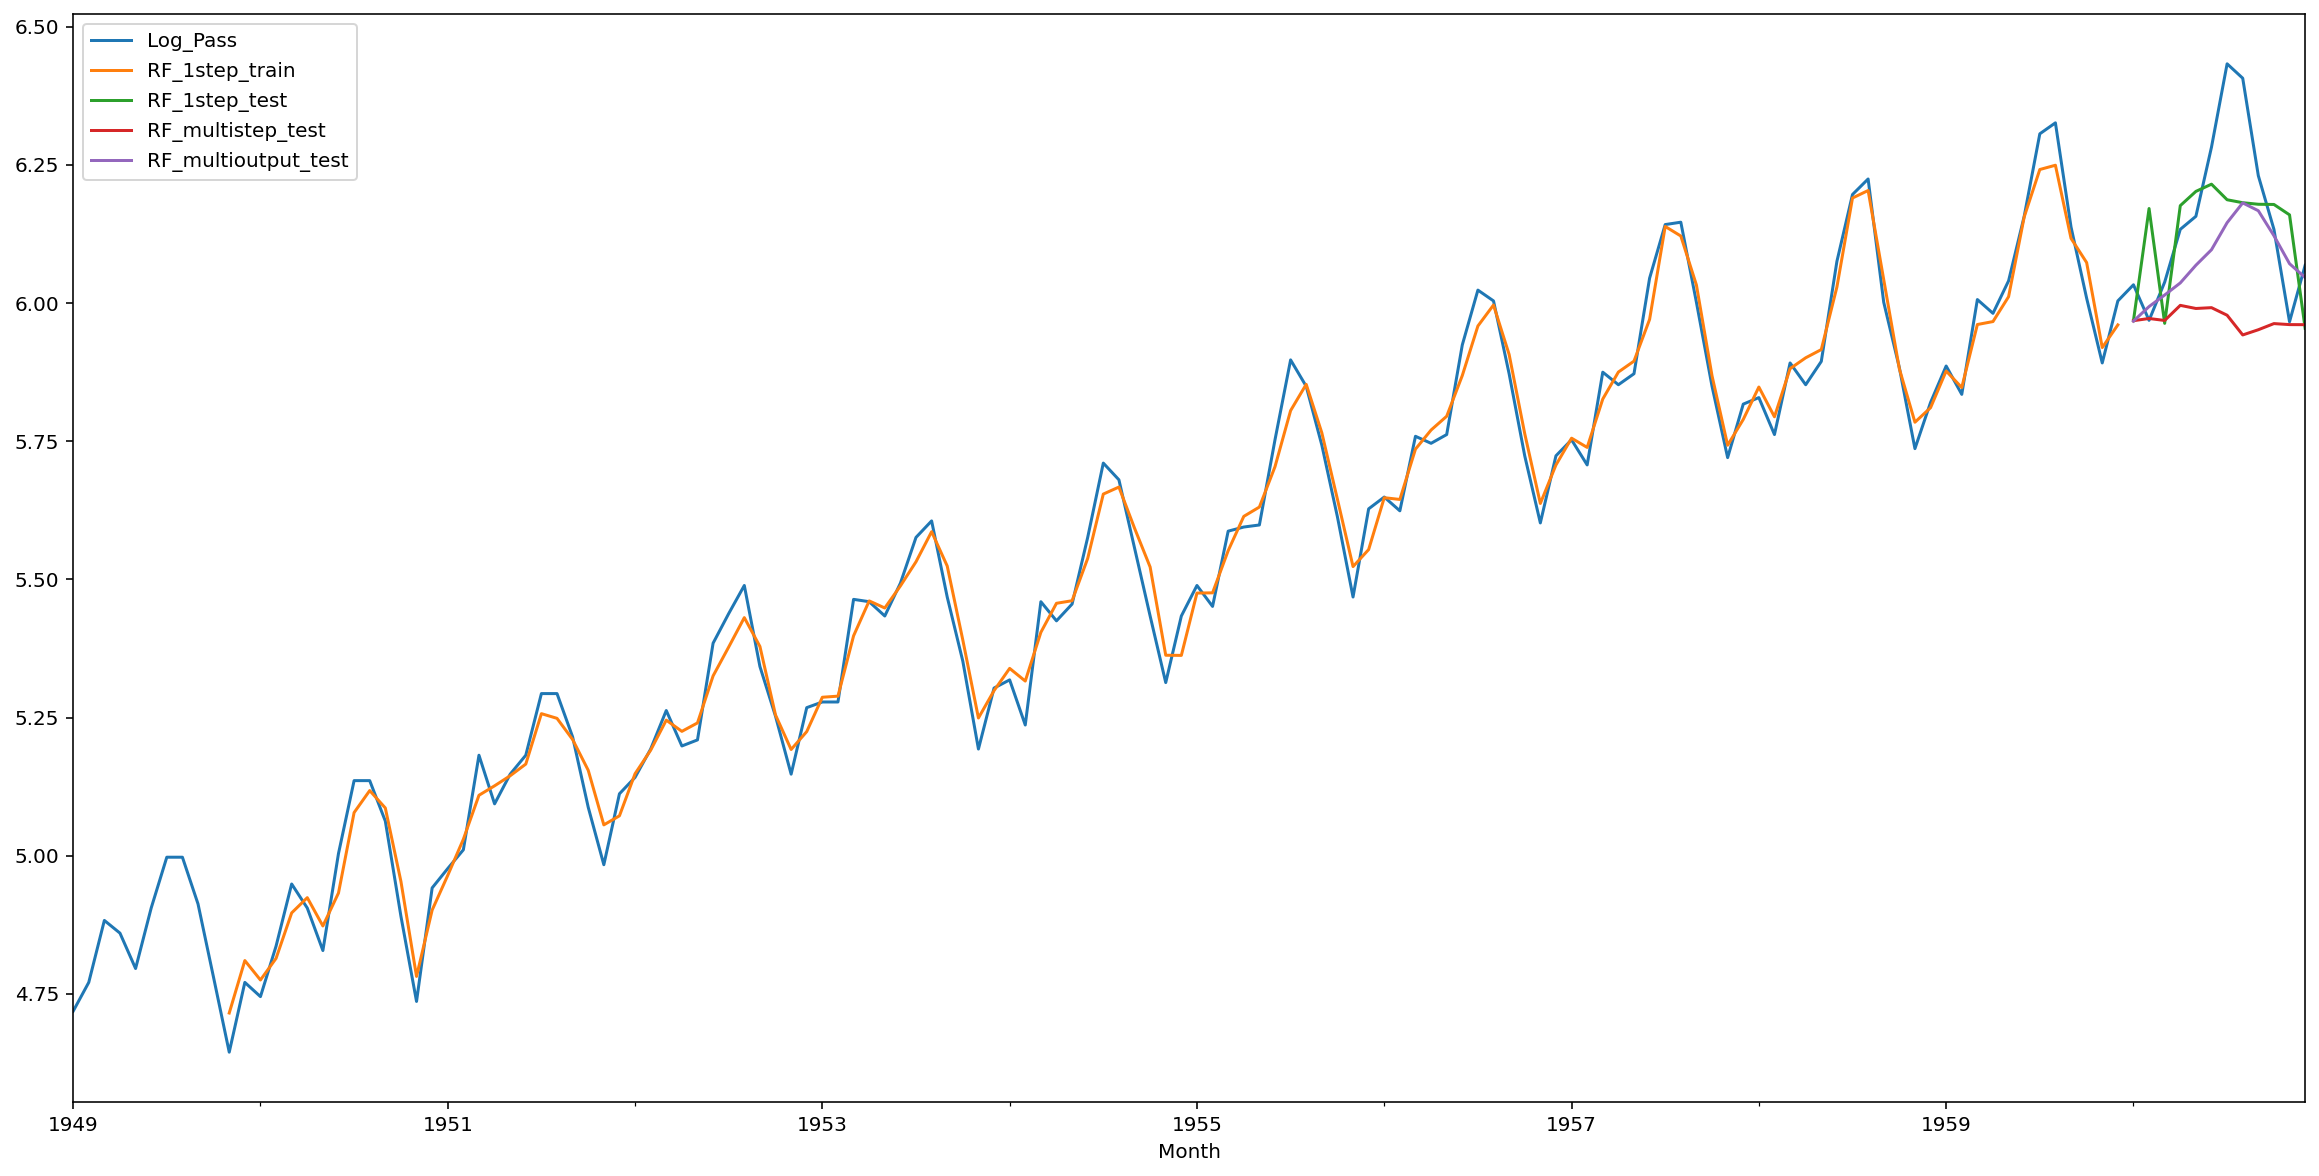

In [272]:
multi_output_forecast(RandomForestRegressor(), 'RF')